In [9]:
import io
import requests
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
# --------------------------------------------------------------------
# 1) Load data from OSF (CSV equivalent of the Stata .dta file)
# --------------------------------------------------------------------

# In Stata:
# copy "https://osf.io/download/dn8je/" "workfile.dta"
# use "workfile.dta", clear
# erase "workfile.dta"

# In Python, read directly from URL into a DataFrame
url = "https://osf.io/download/dn8je/"
response = requests.get(url)
response.raise_for_status()

# Try reading as Stata .dta; if that fails, treat as CSV
# (The original code suggests a Stata file; adjust if needed.)
data_bytes = io.BytesIO(response.content) # Allows to read as a file without writging to disk
try:
    df = pd.read_stata(data_bytes)
except Exception:
    data_bytes.seek(0)
    df = pd.read_csv(data_bytes)


In [3]:
# --------------------------------------------------------------------
# 2) Cleaning & Sample Selection
# --------------------------------------------------------------------

# keep if accommodation_type == "Hotel"
df = df[df["accommodation_type"] == "Hotel"]

# keep if city_actual == "Vienna"
df = df[df["city_actual"] == "Vienna"]

# keep if stars>=3 & stars<=4
df = df[(df["stars"] >= 3) & (df["stars"] <= 4)]

# drop if price > 600
df = df[df["price"] <= 600]

In [4]:
# --------------------------------------------------------------------
# Part I: Binary variable interpretation
# --------------------------------------------------------------------

# gen star4 = (stars==4)
df["star4"] = (df["stars"] == 4).astype(int)

# Means a, b, c
a = df["price"].mean()  # overall mean
b = df.loc[df["star4"] == 1, "price"].mean()
c = df.loc[df["star4"] == 0, "price"].mean()

print(f"a = overall mean price:      {a:9.3f}")
print(f"b = mean price (star4==1):   {b:9.3f}")
print(f"c = mean price (star4==0):   {c:9.3f}")
print(f"b - c (difference in means): {b - c:9.3f}")

# Task 1: Run a basic regression of price on star4
# Stata: reg price star4
# (You can uncomment this to run the regression.)

X = sm.add_constant(df["star4"])
y = df["price"]
model_star4 = sm.OLS(y, X, missing="drop").fit()
print(model_star4.summary())

# Task 2: Explain how the intercept and the coefficient on star4
# relate to the means we calculated before?
# (Conceptual explanation, not code.)

a = overall mean price:        109.976
b = mean price (star4==1):     124.072
c = mean price (star4==0):      93.677
b - c (difference in means):    30.395
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     30.50
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           1.01e-07
Time:                        13:31:46   Log-Likelihood:                -1053.6
No. Observations:                 207   AIC:                             2111.
Df Residuals:                     205   BIC:                             2118.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|

<Axes: xlabel='distance', ylabel='price'>

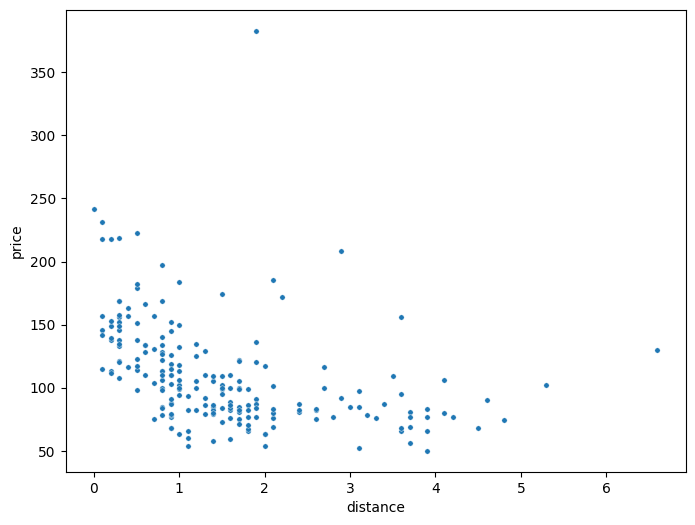

In [5]:
# --------------------------------------------------------------------
# Part II: Basic Visualization & Regression
# --------------------------------------------------------------------

# Scatter + smooth + lfit (LOWESS smooth + linear fit)
# Stata:
# twoway (scatter price distance) (lowess price distance)

# Basic scatter + LOWESS
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="distance", y="price", s=15)

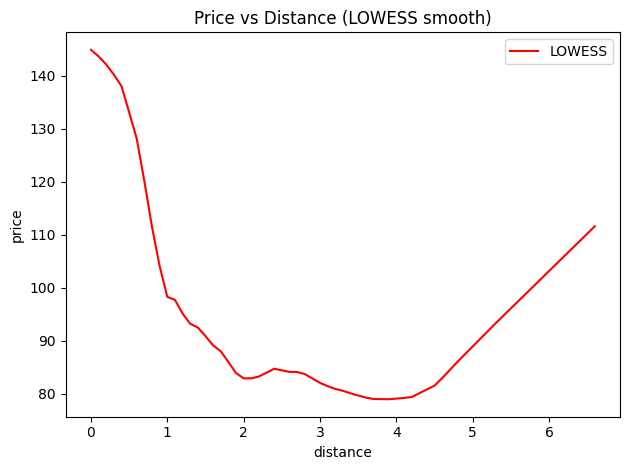

In [6]:
# LOWESS smooth
lowess_result = lowess(df["price"], df["distance"], frac=0.3)
plt.plot(lowess_result[:, 0], lowess_result[:, 1], color="red", label="LOWESS")
plt.title("Price vs Distance (LOWESS smooth)")
plt.xlabel("distance")
plt.ylabel("price")
plt.legend()
plt.tight_layout()
plt.show()  # Uncomment to display

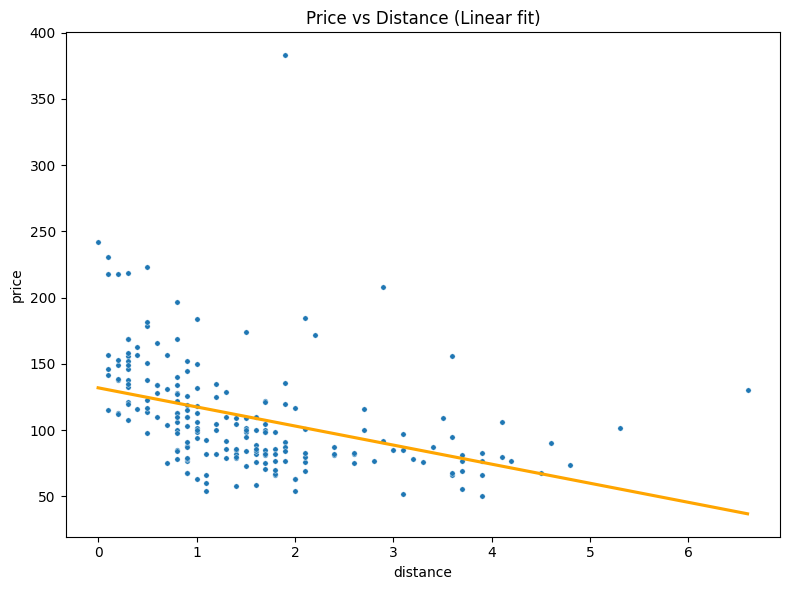

In [7]:
# Task 3: Create a scatterplot with a fit line.
# Stata:
# twoway (scatter price distance) (lfit price distance)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="distance", y="price", s=15)
sns.regplot(data=df, x="distance", y="price", scatter=False, ci=None, color="orange")
plt.title("Price vs Distance (Linear fit)")
plt.xlabel("distance")
plt.ylabel("price")
plt.tight_layout()
plt.show()

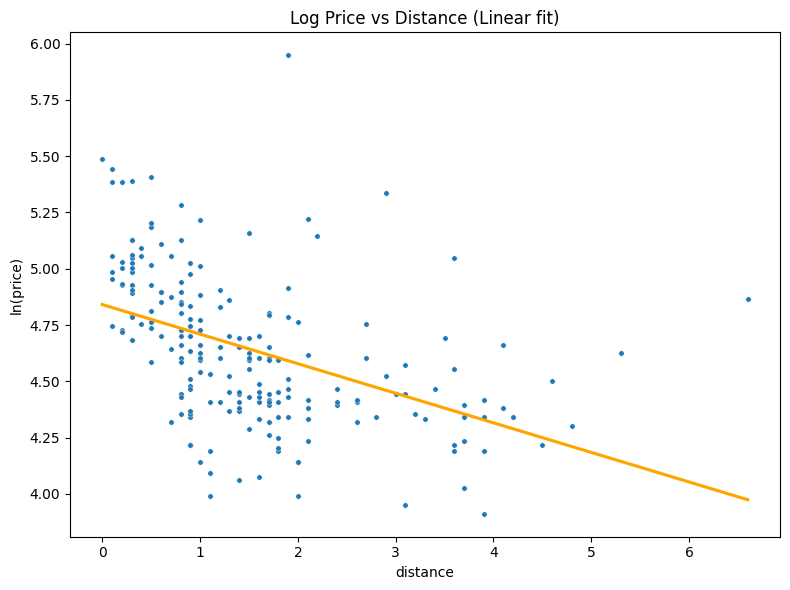

In [16]:
# --------------------------------------------------------------------
# Part III: Transforming variables + more graphs
# --------------------------------------------------------------------

# Basic Model
# Stata:
# reg price distance
# estimates store model1

X_basic = sm.add_constant(df["distance"])
y_basic = df["price"]
model1 = sm.OLS(y_basic, X_basic, missing="drop").fit()

# gen lnprice = ln(price)
df["lnprice"] = np.log(df["price"])

# gen distance2 = distance
# replace distance2 = 0.05 if distance2 < 0.05 & !missing(distance2)
df["distance2"] = df["distance"].copy()
df.loc[df["distance2"] < 0.05, "distance2"] = 0.05

# gen lndistance = ln(distance2)
df["lndistance"] = np.log(df["distance2"])

# Task 5: Graph one of the new variables (log price vs distance), with linear fit
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="distance", y="lnprice", s=15)
sns.regplot(data=df, x="distance", y="lnprice", scatter=False, ci=None, color="orange")
plt.title("Log Price vs Distance (Linear fit)")
plt.xlabel("distance")
plt.ylabel("ln(price)")
plt.tight_layout()
plt.show()

In [11]:
# --------------------------------------------------------------------
# Regressions from slides
# --------------------------------------------------------------------

# reg price distance
reg0 = sm.OLS(df["price"], sm.add_constant(df["distance"]), missing="drop").fit()

# reg lnprice distance
reg1 = sm.OLS(df["lnprice"], sm.add_constant(df["distance"]), missing="drop").fit()

# reg price lndistance
reg2 = sm.OLS(df["price"], sm.add_constant(df["lndistance"]), missing="drop").fit()

# reg lnprice lndistance
reg3 = sm.OLS(df["lnprice"], sm.add_constant(df["lndistance"]), missing="drop").fit()

# Stata:
# estimates table reg0 reg1 reg2 reg3
# estimates table reg0 reg1 reg2 reg3, b(%9.4f) stats(N r2) star

def summarize_model(name, model):
    return {
        "model": name,
        "const_coef": model.params.get("const", np.nan),
        "distance_coef": model.params[[c for c in model.params.index if c != "const"][0]],
        "N": int(model.nobs),
        "R2": model.rsquared,
    }

summary_rows = [
    summarize_model("reg0: price ~ distance", reg0),
    summarize_model("reg1: lnprice ~ distance", reg1),
    summarize_model("reg2: price ~ lndistance", reg2),
    summarize_model("reg3: lnprice ~ lndistance", reg3),
]

summary_table = pd.DataFrame(summary_rows)
print("\nRegression summary table:")
print(summary_table.to_string(index=False))


Regression summary table:
                     model  const_coef  distance_coef   N       R2
    reg0: price ~ distance  132.016973     -14.406420 207 0.157069
  reg1: lnprice ~ distance    4.841105      -0.131303 207 0.205104
  reg2: price ~ lndistance  112.417094     -24.768264 207 0.279630
reg3: lnprice ~ lndistance    4.661486      -0.215771 207 0.333599


In [12]:
# --------------------------------------------------------------------
# Task 6: Regression with splines (conceptual placeholder)
# --------------------------------------------------------------------
# In Stata:
# mkspline creates e.g.
#   s1 = min(distance,1)
#   s2 = max(0, min(distance,4) - 1)
#   s3 = max(0, distance - 4)
#
# In Python, a direct manual construction could look like:
#
df["s1"] = np.minimum(df["distance"], 1)
df["s2"] = np.maximum(0, np.minimum(df["distance"], 4) - 1)
df["s3"] = np.maximum(0, df["distance"] - 4)
#
# Then run a regression:
X_spline = sm.add_constant(df[["s1", "s2", "s3"]])
y_spline = df["price"]
spline_model = sm.OLS(y_spline, X_spline, missing="drop").fit()
print(spline_model.summary())
#
# Compare the R-squared with the simple linear model.

if __name__ == "__main__":
    # Optionally, save figures instead of showing
    # plt.savefig("figure_name.png")
    pass

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     30.16
Date:                Thu, 15 Jan 2026   Prob (F-statistic):           3.63e-16
Time:                        13:33:34   Log-Likelihood:                -1029.9
No. Observations:                 207   AIC:                             2068.
Df Residuals:                     203   BIC:                             2081.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        174.3196      7.861     22.176      0.0